In [22]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [23]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [24]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [25]:
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)


In [ ]:
print(os.getcwd())

/content


In [26]:
#import sys

#sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1

In [27]:
set_all_seeds(RANDOM_SEED)

##########################
### Dataset
##########################

train_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                       transforms.RandomCrop((64, 64)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                      transforms.CenterCrop((64, 64)),
                                      transforms.ToTensor()])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    num_workers=2,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

Files already downloaded and verified


In [28]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model,
                                      optimizer=optimizer, device=DEVICE,
                                      train_loader=train_loader, valid_loader=valid_loader,
                                      logging_interval=50)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3033
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.0525
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.9257
Epoch: 001/040 | Batch 0150/0175 | Loss: 1.8106
***Epoch: 001/040 | Train. Acc.: 34.214% | Loss: 1.682
***Epoch: 001/040 | Valid. Acc.: 35.720% | Loss: 1.652
Time elapsed: 1.02 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.7399
Epoch: 002/040 | Batch 0050/0175 | Loss: 1.5377
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.5154
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.5036
***Epoch: 002/040 | Train. Acc.: 44.989% | Loss: 1.458
***Epoch: 002/040 | Valid. Acc.: 46.640% | Loss: 1.445
Time elapsed: 2.00 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.5121
Epoch: 003/040 | Batch 0050/0175 | Loss: 1.4856
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.3800
Epoch: 003/040 | Batch 0150/0175 | Loss: 1.3285
***Epoch: 003/040 | Train. Acc.: 49.306% | Loss: 1.381
***Epoch: 003/040 | Valid. Acc.: 50.080% | Loss: 1.373
Time elapsed: 2.98 min
Epoch: 004/040 | Batch 00

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

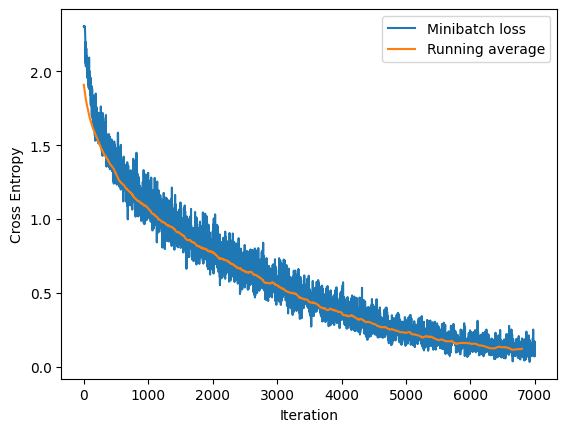

In [ ]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list,
                     np.ones(200,)/200, mode='valid'),
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

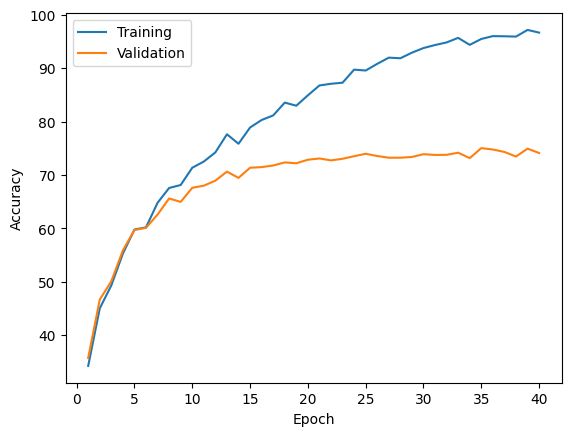

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):

    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)

    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)

    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)


print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 74.10%
Validation ACC: 74.10%
Test ACC: 72.87%


In [30]:
def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

class Square(torch.nn.Module):
    def forward(self, x):
        return x**2

class ApproxReLU(torch.nn.Module):
    def forward(self, x):
        return _approximated_ReLU(x)

class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

**Approximated Alexnet**

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        # self.features = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=3, stride=2),

        #     nn.Conv2d(64, 192, kernel_size=5, padding=2),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=3, stride=2),

        #     nn.Conv2d(192, 384, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),

        #     nn.Conv2d(384, 256, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),

        #     nn.Conv2d(256, 256, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=3, stride=2),
        # )
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # self.classifier = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(256 * 6 * 6, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(0.5),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(4096, num_classes)
        # )
        self.FC1 = nn.Linear(256*6*6, 4096)
        self.relu6 = nn.ReLU(inplace=True)
        self.FC2 = nn.Linear(4096, 4096)
        self.relu7 = nn.ReLU(inplace=True)
        self.FC3 = nn.Linear(4096, num_classes)

    # def forward(self, x):
    #     x = self.features(x)
    #     x = self.avgpool(x)
    #     x = x.view(x.size(0), 256 * 6 * 6)
    #     logits = self.classifier(x)
    #     probas = F.softmax(logits, dim=1)
    #     return logits
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.FC1(x)
        x = self.relu6(x)
        x = self.FC2(x)
        x = self.relu7(x)
        x = self.FC3(x)

        return x

In [35]:
class M7(nn.Module):

    def __init__(self, num_classes):
        super(M7, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = ApproxReLU()
        self.maxpool1 = torch.nn.AvgPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = ApproxReLU()
        self.maxpool2 = torch.nn.AvgPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = ApproxReLU()

        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = ApproxReLU()

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = ApproxReLU()
        self.maxpool3 = torch.nn.AvgPool2d(kernel_size=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # self.classifier = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(256 * 6 * 6, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(0.5),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(4096, num_classes)
        # )
        self.FC1 = nn.Linear(256*6*6, 4096)
        self.relu6 = ApproxReLU()
        self.FC2 = nn.Linear(4096, 4096)
        self.relu7 = ApproxReLU()
        self.FC3 = nn.Linear(4096, num_classes)

    # def forward(self, x):
    #     x = self.features(x)
    #     x = self.avgpool(x)
    #     x = x.view(x.size(0), 256 * 6 * 6)
    #     logits = self.classifier(x)
    #     probas = F.softmax(logits, dim=1)
    #     return logits
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.FC1(x)
        x = self.relu6(x)
        x = self.FC2(x)
        x = self.relu7(x)
        x = self.FC3(x)

        return x

In [36]:
model1 = M7(NUM_CLASSES)
model1.to(DEVICE)

optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)

In [37]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model1,
                                      optimizer=optimizer, device=DEVICE,
                                      train_loader=train_loader, valid_loader=valid_loader,
                                      logging_interval=50)

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3279
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.3072
Epoch: 001/040 | Batch 0100/0175 | Loss: 2.1737
Epoch: 001/040 | Batch 0150/0175 | Loss: 2.1498
***Epoch: 001/040 | Train. Acc.: 19.777% | Loss: 2.091
***Epoch: 001/040 | Valid. Acc.: 19.880% | Loss: 2.085
Time elapsed: 1.04 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 2.1073
Epoch: 002/040 | Batch 0050/0175 | Loss: 2.0759
Epoch: 002/040 | Batch 0100/0175 | Loss: 2.1310
Epoch: 002/040 | Batch 0150/0175 | Loss: 2.0986
***Epoch: 002/040 | Train. Acc.: 19.163% | Loss: 2.093
***Epoch: 002/040 | Valid. Acc.: 19.580% | Loss: 2.084
Time elapsed: 2.08 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 2.0053
Epoch: 003/040 | Batch 0050/0175 | Loss: 2.0350
Epoch: 003/040 | Batch 0100/0175 | Loss: 2.1622
Epoch: 003/040 | Batch 0150/0175 | Loss: 2.0057
***Epoch: 003/040 | Train. Acc.: 22.179% | Loss: 2.037
***Epoch: 003/040 | Valid. Acc.: 22.320% | Loss: 2.032
Time elapsed: 3.13 min
Epoch: 004/040 | Batch 00

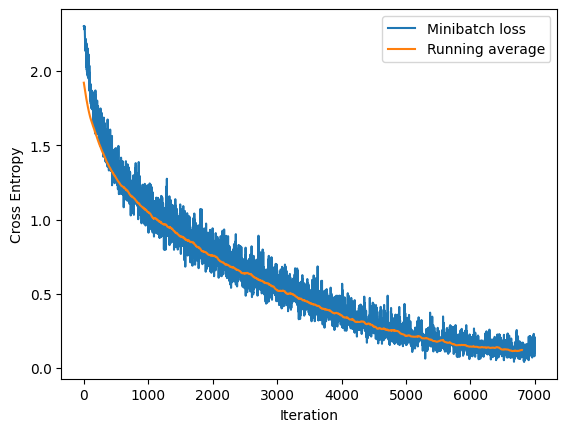

In [ ]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list,
                     np.ones(200,)/200, mode='valid'),
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):

    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)

    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)

    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)


print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 74.10%
Validation ACC: 74.10%
Test ACC: 72.87%
